# Inferring parameters of SDEs using a Euler-Maruyama scheme

_This notebook is derived from a presentation prepared for the Theoretical Neuroscience Group, Institute of Systems Neuroscience at Aix-Marseile University._

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import scipy as sp

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Toy model 1

Here's a scalar linear SDE in symbolic form

$ dX_t = \lambda X_t + \sigma^2 dW_t $

discretized with the Euler-Maruyama scheme

In [3]:
# parameters
lam = -0.78
s2 = 5e-3
N = 200
dt = 1e-1

# time series
x = 0.1
x_t = []

# simulate
for i in range(N):
    x += dt * lam * x + np.sqrt(dt) * s2 * np.random.randn()
    x_t.append(x)

x_t = np.array(x_t)

# z_t noisy observation
z_t = x_t + np.random.randn(x_t.size) * 5e-3

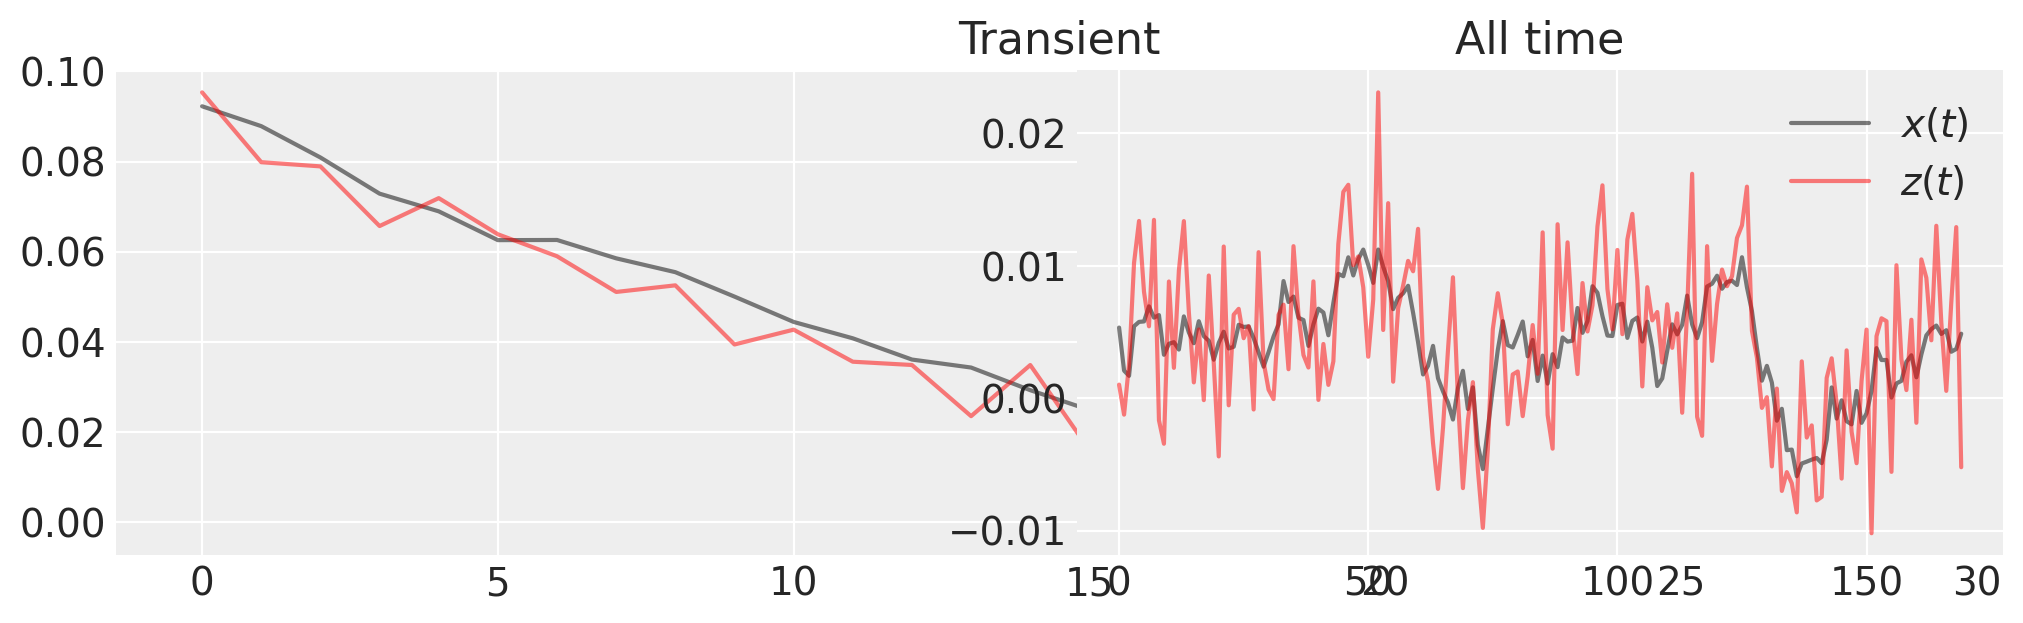

In [4]:
plt.figure(figsize=(10, 3))
plt.plot(x_t[:30], "k", label="$x(t)$", alpha=0.5)
plt.plot(z_t[:30], "r", label="$z(t)$", alpha=0.5)
plt.title("Transient")
plt.legend()
plt.subplot(122)
plt.plot(x_t[30:], "k", label="$x(t)$", alpha=0.5)
plt.plot(z_t[30:], "r", label="$z(t)$", alpha=0.5)
plt.title("All time")
plt.legend();

What is the inference we want to make? Since we've made a noisy observation of the generated time series, we need to estimate both $x(t)$ and $\lambda$.

First, we rewrite our SDE as a function returning a tuple of the drift and diffusion coefficients

In [5]:
def lin_sde(x, lam):
    return lam * x, s2

Next, we describe the probability model as a set of three stochastic variables, `lam`, `xh`, and `zh`:

In [6]:
with pm.Model() as model:
    # uniform prior, but we know it must be negative
    l = pm.Flat("l")

    # "hidden states" following a linear SDE distribution
    # parametrized by time step (det. variable) and lam (random variable)
    xh = pm.EulerMaruyama("xh", dt=dt, sde_fn=lin_sde, sde_pars=(l,), shape=N)

    # predicted observation
    zh = pm.Normal("zh", mu=xh, sigma=5e-3, observed=z_t)

/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/distributions/timeseries.py:986: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Once the model is constructed, we perform inference, i.e. sample from the posterior distribution, in the following steps:

In [7]:
with model:
    trace = pm.sample()

/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/initial_point.py:235: UserWarning: Moment not defined for variable xh of type EulerMaruyamaRV, defaulting to a draw from the prior. This can lead to difficulties during tuning. You can manually define an initval or implement a support_point dispatched function for this distribution.
  warnings.warn(
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/initial_point.py:235: UserWarning: Moment not defined for variable xh of type EulerMaruyamaRV, defaulting to a draw from the prior. This can lead to difficulties during tuning. You can manually define an initval or implement a support_point dispatched function for this distribution.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/initial_point.py:235: UserWarning: Momen

Output()

/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/initial_point.py:235: UserWarning: Moment not defined for variable xh of type EulerMaruyamaRV, defaulting to a draw from the prior. This can lead to difficulties during tuning. You can manually define an initval or implement a support_point dispatched function for this distribution.
  warnings.warn(
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/initial_point.py:235: UserWarning: Moment not defined for variable xh of type EulerMaruyamaRV, defaulting to a draw from the prior. This can lead to difficulties during tuning. You can manually define an initval or implement a support_point dispatched function for this distribution.
  warnings.warn(
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/initial_point.py:235: UserWarning: Moment not defined for variable xh of type EulerMaruyamaRV, defaulting to a draw 

Next, we plot some basic statistics on the samples from the posterior,

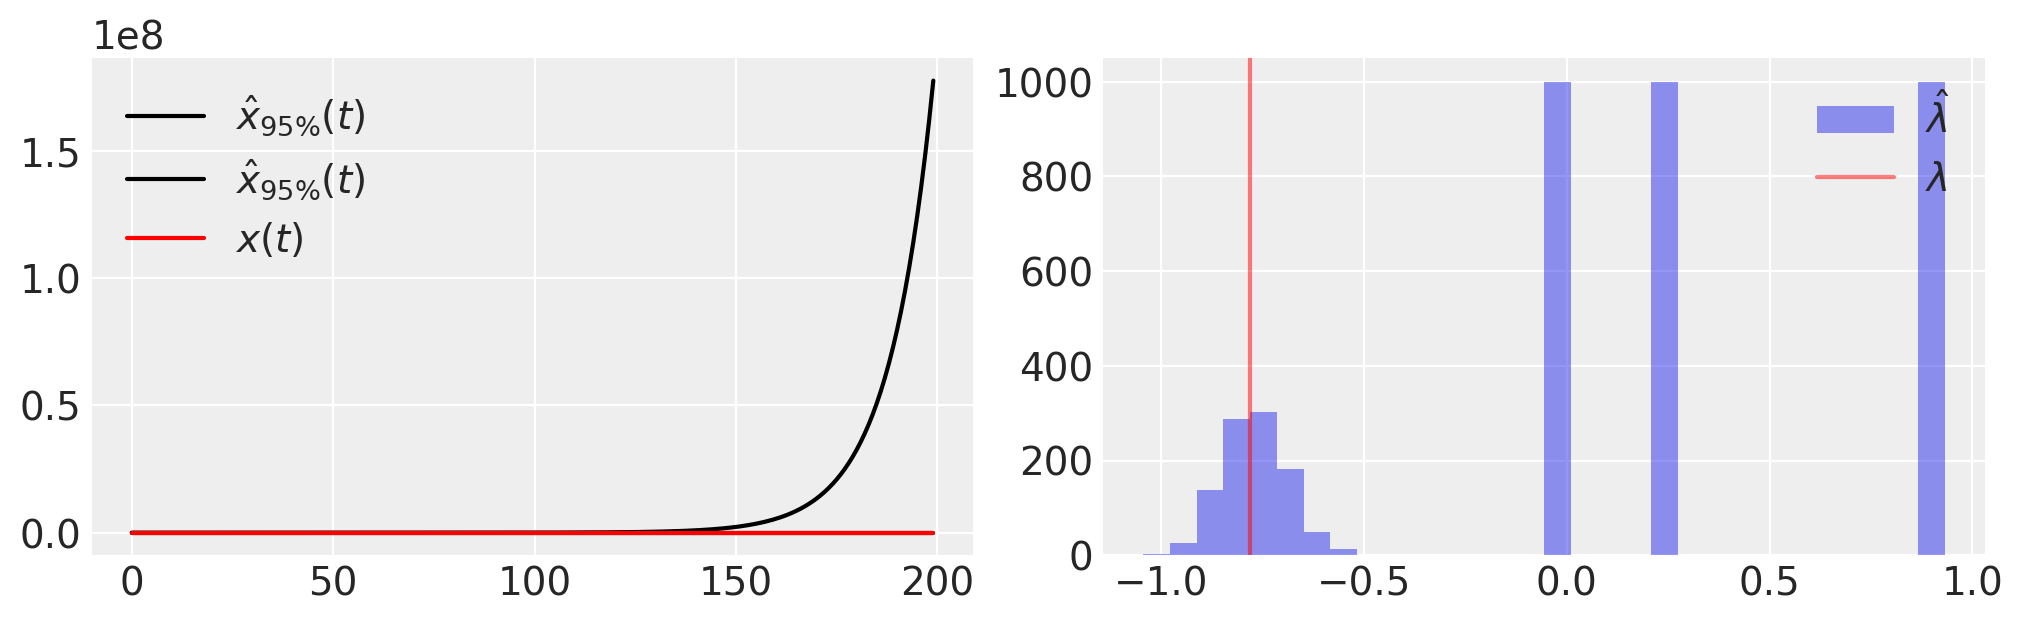

In [8]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(
    trace.posterior.quantile((0.025, 0.975), dim=("chain", "draw"))["xh"].values.T,
    "k",
    label=r"$\hat{x}_{95\%}(t)$",
)
plt.plot(x_t, "r", label="$x(t)$")
plt.legend()

plt.subplot(122)
plt.hist(az.extract(trace.posterior)["l"], 30, label=r"$\hat{\lambda}$", alpha=0.5)
plt.axvline(lam, color="r", label=r"$\lambda$", alpha=0.5)
plt.legend();

A model can fit the data precisely and still be wrong; we need to use _posterior predictive checks_ to assess if, under our fit model, the data our likely.

In other words, we 
- assume the model is correct
- simulate new observations
- check that the new observations fit with the original data

In [9]:
# generate trace from posterior
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [zh]


Output()

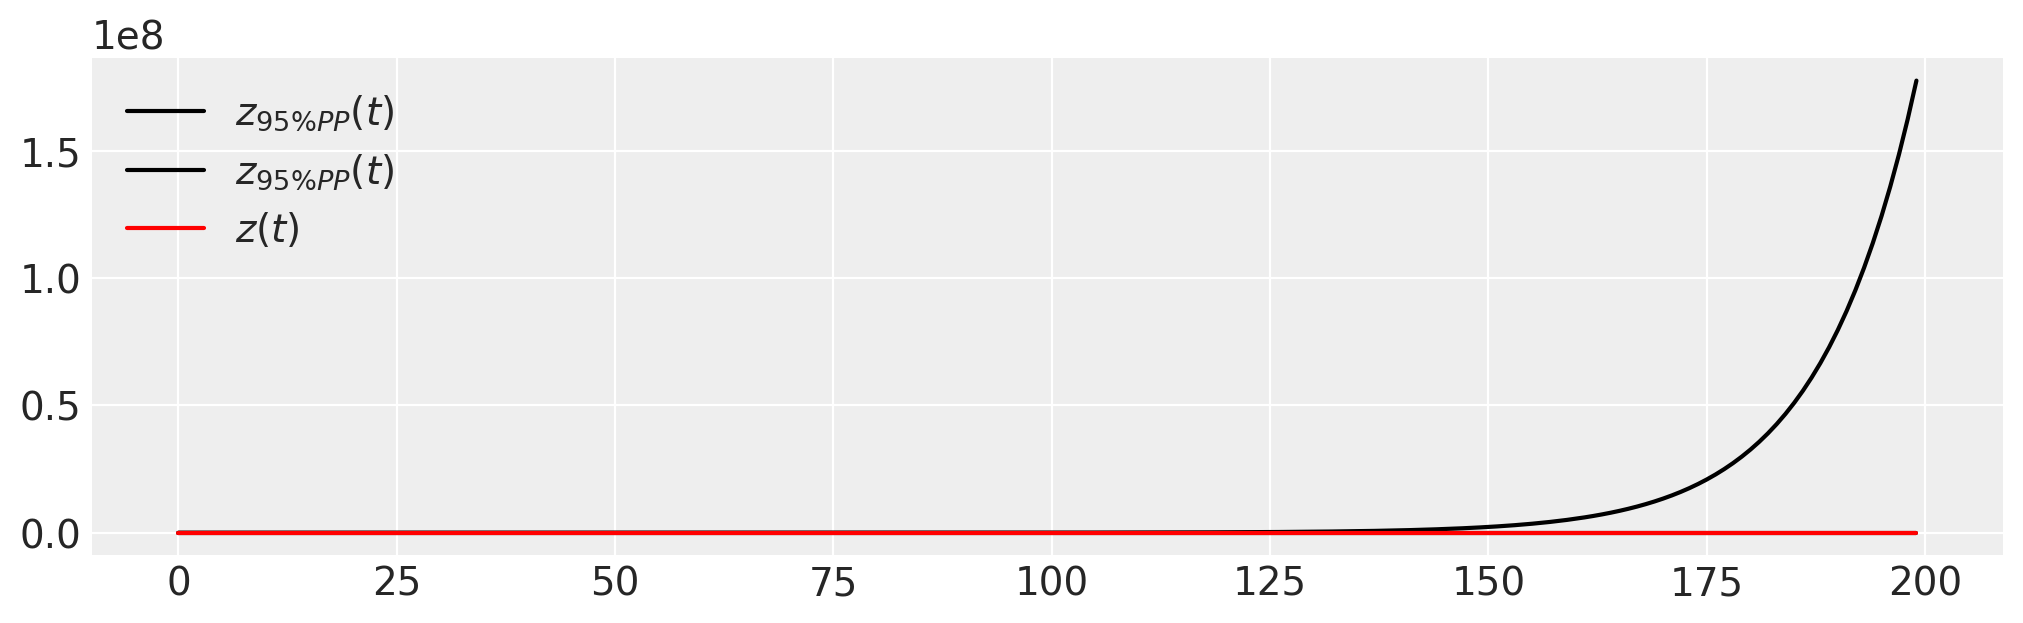

In [10]:
plt.figure(figsize=(10, 3))
plt.plot(
    trace.posterior_predictive.quantile((0.025, 0.975), dim=("chain", "draw"))["zh"].values.T,
    "k",
    label=r"$z_{95\% PP}(t)$",
)
plt.plot(z_t, "r", label="$z(t)$")
plt.legend();

Note that 

- inference also estimates the initial conditions
- the observed data $z(t)$ lies fully within the 95% interval of the PPC.
- there are many other ways of evaluating fit

### Toy model 2

As the next model, let's use a 2D deterministic oscillator, 
\begin{align}
\dot{x} &= \tau (x - x^3/3 + y) \\
\dot{y} &= \frac{1}{\tau} (a - x)
\end{align}

with noisy observation $z(t) = m x + (1 - m) y + N(0, 0.05)$.

In [ ]:
N, tau, a, m, s2 = 200, 3.0, 1.05, 0.2, 1e-1
xs, ys = [0.0], [1.0]
for i in range(N):
    x, y = xs[-1], ys[-1]
    dx = tau * (x - x**3.0 / 3.0 + y)
    dy = (1.0 / tau) * (a - x)
    xs.append(x + dt * dx + np.sqrt(dt) * s2 * np.random.randn())
    ys.append(y + dt * dy + np.sqrt(dt) * s2 * np.random.randn())
xs, ys = np.array(xs), np.array(ys)
zs = m * xs + (1 - m) * ys + np.random.randn(xs.size) * 0.1

plt.figure(figsize=(10, 2))
plt.plot(xs, label="$x(t)$")
plt.plot(ys, label="$y(t)$")
plt.plot(zs, label="$z(t)$")
plt.legend()

Now, estimate the hidden states $x(t)$ and $y(t)$, as well as parameters $\tau$, $a$ and $m$.

As before, we rewrite our SDE as a function returned drift & diffusion coefficients:

In [ ]:
def osc_sde(xy, tau, a):
    x, y = xy[:, 0], xy[:, 1]
    dx = tau * (x - x**3.0 / 3.0 + y)
    dy = (1.0 / tau) * (a - x)
    dxy = pt.stack([dx, dy], axis=0).T
    return dxy, s2

As before, the Euler-Maruyama discretization of the SDE is written as a prediction of the state at step $i+1$ based on the state at step $i$.

We can now write our statistical model as before, with uninformative priors on $\tau$, $a$ and $m$:

In [ ]:
xys = np.c_[xs, ys]

with pm.Model() as model:
    tau_h = pm.Uniform("tau_h", lower=0.1, upper=5.0)
    a_h = pm.Uniform("a_h", lower=0.5, upper=1.5)
    m_h = pm.Uniform("m_h", lower=0.0, upper=1.0)
    xy_h = pm.EulerMaruyama(
        "xy_h", dt=dt, sde_fn=osc_sde, sde_pars=(tau_h, a_h), shape=xys.shape, initval=xys
    )
    zh = pm.Normal("zh", mu=m_h * xy_h[:, 0] + (1 - m_h) * xy_h[:, 1], sigma=0.1, observed=zs)

In [ ]:
pm.__version__

In [ ]:
with model:
    trace = pm.sample(2000, tune=1000)

Again, the result is a set of samples from the posterior, including our parameters of interest but also the hidden states

In [ ]:
figure(figsize=(10, 6))
subplot(211)
plot(percentile(trace[xyh][..., 0], [2.5, 97.5], axis=0).T, "k", label=r"$\hat{x}_{95\%}(t)$")
plot(xs, "r", label="$x(t)$")
legend(loc=0)
subplot(234), hist(trace["τh"]), axvline(τ), xlim([1.0, 4.0]), title("τ")
subplot(235), hist(trace["ah"]), axvline(a), xlim([0, 2.0]), title("a")
subplot(236), hist(trace["mh"]), axvline(m), xlim([0, 1]), title("m")
tight_layout()

Again, we can perform a posterior predictive check, that our data are likely given the fit model

In [ ]:
# generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, model=model)

# plot with data
figure(figsize=(10, 3))
plot(percentile(ppc_trace["zh"], [2.5, 97.5], axis=0).T, "k", label=r"$z_{95\% PP}(t)$")
plot(zs, "r", label="$z(t)$")
legend()

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w